# پیٹر اور بھیڑیا: حقیقت پسندانہ ماحول

ہمارے منظرنامے میں، پیٹر تقریباً بغیر تھکے یا بھوکے ہوئے ادھر ادھر گھوم سکتا تھا۔ ایک زیادہ حقیقت پسندانہ دنیا میں، اسے وقتاً فوقتاً بیٹھ کر آرام کرنا ہوگا اور خود کو کھلانا ہوگا۔ آئیے اپنی دنیا کو زیادہ حقیقت پسند بناتے ہیں، درج ذیل اصولوں کو نافذ کرکے:

1. ایک جگہ سے دوسری جگہ جانے پر، پیٹر کی **توانائی** کم ہوتی ہے اور اسے کچھ **تھکن** ہو جاتی ہے۔
2. پیٹر سیب کھا کر مزید توانائی حاصل کر سکتا ہے۔
3. پیٹر درخت کے نیچے یا گھاس پر آرام کرکے تھکن سے چھٹکارا پا سکتا ہے (یعنی ایسی جگہ پر جانا جہاں درخت یا گھاس ہو - سبز میدان)۔
4. پیٹر کو بھیڑیا تلاش کرکے اسے مارنا ہوگا۔
5. بھیڑیا مارنے کے لیے، پیٹر کے پاس توانائی اور تھکن کی مخصوص سطحیں ہونی چاہئیں، ورنہ وہ جنگ ہار جائے گا۔


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

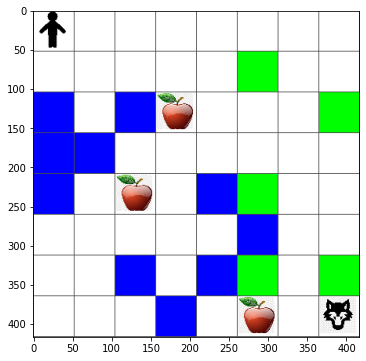

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## حالت کی وضاحت

ہمارے نئے کھیل کے قواعد میں، ہمیں ہر بورڈ کی حالت پر توانائی اور تھکن کا حساب رکھنا ہوگا۔ اس لیے ہم ایک آبجیکٹ `state` بنائیں گے جو موجودہ مسئلے کی حالت کے بارے میں تمام ضروری معلومات رکھے گا، جس میں بورڈ کی حالت، توانائی اور تھکن کی موجودہ سطحیں، اور یہ کہ آیا ہم آخری حالت میں بھیڑیا کو شکست دے سکتے ہیں یا نہیں:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

چلو مسئلہ کو بے ترتیب چال کے ذریعے حل کرنے کی کوشش کرتے ہیں اور دیکھتے ہیں کہ ہم کامیاب ہوتے ہیں:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## انعامی فنکشن

انعامی فنکشن ایک ایسا میکانزم ہے جو ایجنٹ کے اعمال کی کارکردگی کا اندازہ لگانے کے لیے استعمال ہوتا ہے۔ یہ فنکشن ایجنٹ کو یہ بتاتا ہے کہ اس کے اعمال کتنے مؤثر ہیں اور اسے اپنے مقاصد کے قریب لے جا رہے ہیں یا نہیں۔

### انعامی فنکشن کی اہمیت

ایک اچھی طرح سے ڈیزائن کیا گیا انعامی فنکشن ایجنٹ کو صحیح سمت میں رہنمائی کرنے میں مدد دیتا ہے۔ اگر انعامی فنکشن ناقص ہو تو ایجنٹ غیر متوقع یا غیر مطلوب رویے کا مظاہرہ کر سکتا ہے۔

[!NOTE] انعامی فنکشن کو ڈیزائن کرتے وقت، یہ یقینی بنائیں کہ یہ ایجنٹ کے لیے واضح اور قابلِ پیمائش ہو۔

### انعامی فنکشن کی مثال

ذیل میں ایک سادہ انعامی فنکشن کی مثال دی گئی ہے:

```python
def reward_function(state, action):
    if state == "goal_state":
        return 100  # ایجنٹ کو ہدف تک پہنچنے پر انعام
    elif action == "invalid_action":
        return -10  # غیر درست عمل پر جرمانہ
    else:
        return 0  # دیگر صورتوں میں کوئی انعام نہیں
```

### انعامی فنکشن کو بہتر بنانا

انعامی فنکشن کو بہتر بنانے کے لیے درج ذیل نکات پر غور کریں:

1. **واضح مقاصد طے کریں:** انعامی فنکشن کو ایجنٹ کے مقاصد کے مطابق ڈیزائن کریں۔
2. **غیر مطلوب رویے کو روکیں:** ایسے اعمال پر جرمانہ لگائیں جو غیر مطلوب نتائج پیدا کر سکتے ہیں۔
3. **مراحل میں انعام دیں:** ایجنٹ کو چھوٹے مراحل میں انعام دے کر اسے حوصلہ افزائی کریں۔

[!TIP] انعامی فنکشن کو بار بار جانچیں اور ایجنٹ کے رویے کا تجزیہ کریں تاکہ اسے بہتر بنایا جا سکے۔

### عام غلطیاں

انعامی فنکشن ڈیزائن کرتے وقت درج ذیل عام غلطیوں سے بچیں:

- **غیر متوازن انعامات:** اگر انعامات بہت زیادہ یا بہت کم ہوں تو ایجنٹ غیر متوقع رویہ اختیار کر سکتا ہے۔
- **غلط ترجیحات:** انعامی فنکشن کو اس طرح ڈیزائن کریں کہ یہ ایجنٹ کو صحیح ترجیحات پر توجہ دینے میں مدد دے۔
- **غیر واضح انعامات:** انعامی فنکشن کو واضح اور آسان رکھیں تاکہ ایجنٹ اسے سمجھ سکے۔

[!WARNING] انعامی فنکشن میں چھوٹی سی غلطی بھی ایجنٹ کے رویے پر بڑا اثر ڈال سکتی ہے، اس لیے اسے احتیاط سے ڈیزائن کریں۔

### نتیجہ

انعامی فنکشن ایجنٹ کے لیے ایک رہنما اصول کے طور پر کام کرتا ہے۔ ایک مؤثر انعامی فنکشن ایجنٹ کو مطلوبہ نتائج حاصل کرنے میں مدد دیتا ہے، جبکہ ایک ناقص انعامی فنکشن ایجنٹ کو غلط سمت میں لے جا سکتا ہے۔


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## کیو-لرننگ الگورتھم

اصل لرننگ الگورتھم تقریباً ویسا ہی رہتا ہے، ہم صرف `state` استعمال کرتے ہیں بجائے صرف بورڈ پوزیشن کے۔


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

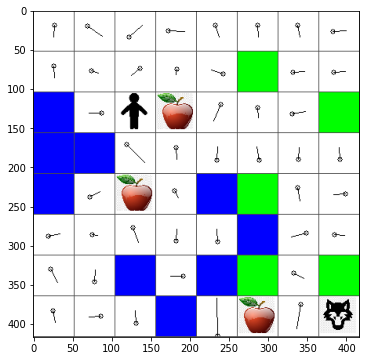

In [11]:
m.plot(Q)

## نتائج

چلیں دیکھتے ہیں کہ کیا ہم پیٹر کو بھیڑیا سے لڑنے کی تربیت دینے میں کامیاب ہوئے!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


ہم اب ڈوبنے کے بہت کم کیسز دیکھتے ہیں، لیکن پیٹر ابھی بھی ہمیشہ بھیڑیا کو مارنے کے قابل نہیں ہوتا۔ تجربہ کرنے کی کوشش کریں اور دیکھیں کہ کیا آپ ہائپر پیرامیٹرز کے ساتھ کھیل کر اس نتیجے کو بہتر بنا سکتے ہیں۔


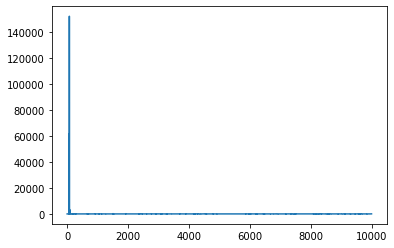

In [13]:
plt.plot(lpath)


---

**ڈسکلیمر**:  
یہ دستاویز AI ترجمہ سروس [Co-op Translator](https://github.com/Azure/co-op-translator) کا استعمال کرتے ہوئے ترجمہ کی گئی ہے۔ ہم درستگی کے لیے کوشش کرتے ہیں، لیکن براہ کرم آگاہ رہیں کہ خودکار ترجمے میں غلطیاں یا غیر درستیاں ہو سکتی ہیں۔ اصل دستاویز کو اس کی اصل زبان میں مستند ذریعہ سمجھا جانا چاہیے۔ اہم معلومات کے لیے، پیشہ ور انسانی ترجمہ کی سفارش کی جاتی ہے۔ ہم اس ترجمے کے استعمال سے پیدا ہونے والی کسی بھی غلط فہمی یا غلط تشریح کے ذمہ دار نہیں ہیں۔
